In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys 
import numpy.ma as ma
import scipy.stats as st
import scipy.signal as si
from astropy.io import fits
from astropy.table import Table
import scipy.ndimage.morphology as morph
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

sys.path.insert(0,'../lib')

import detection_tools as dt
import detection_preprocessing as dp
import strategy_detection_pose as sdp
import mle_sparse_est as mse

import strategy_detection_pose as sd

%load_ext autoreload

%autoreload 2

In [2]:
# Version information
version = 1.4
# source dir
#nom_dossier='../results/sources_udf10/'

nom_dossier='../data/udf10_lya_sources_v0/'

In [8]:
sys.path.insert(0,'../MPDAF')
import mpdaf

from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import Cube
#from mpdaf.obj import CubeDisk

from mpdaf.sdetect import Source, SourceList
from mpdaf.sdetect import Catalog

In [5]:
def calcul_fwhm(lam):
    """
    Full-Width at Half Maximum computation for the HDFS datacube.
    See Bacon et al., 2015, *The MUSE 3D View of the Hubble Deep Field South*.
    
    :param float lam: wavelength to perform the computation.
    
    """
    return -1.625*10**(-4) *lam + 4.5375

In [6]:

#cube = Cube('../data/udf10/DATACUBE-PROPVAR-ZAP_UDF-10.fits')
cube = Cube('../data/DATACUBE_UDF-10.fits')
cube.info()

[INFO] 3681 x 322 x 323 Cube (../data/DATACUBE_UDF-10.fits)
INFO:mpdaf.obj.data:3681 x 322 x 323 Cube (../data/DATACUBE_UDF-10.fits)
[INFO] .data(3681 x 322 x 323) (1e-20 erg / (Angstrom cm2 s)), .var(3681 x 322 x 323)
INFO:mpdaf.obj.data:.data(3681 x 322 x 323) (1e-20 erg / (Angstrom cm2 s)), .var(3681 x 322 x 323)
[INFO] center:(-27:46:43.6667,03:32:38.6806) size in arcsec:(64.400,64.600) step in arcsec:(0.200,0.200) rot:-0.0 deg
INFO:mpdaf.obj.coords:center:(-27:46:43.6667,03:32:38.6806) size in arcsec:(64.400,64.600) step in arcsec:(0.200,0.200) rot:-0.0 deg
[INFO] wavelength: min:4750.00 max:9350.00 step:1.25 Angstrom
INFO:mpdaf.obj.coords:wavelength: min:4750.00 max:9350.00 step:1.25 Angstrom


/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


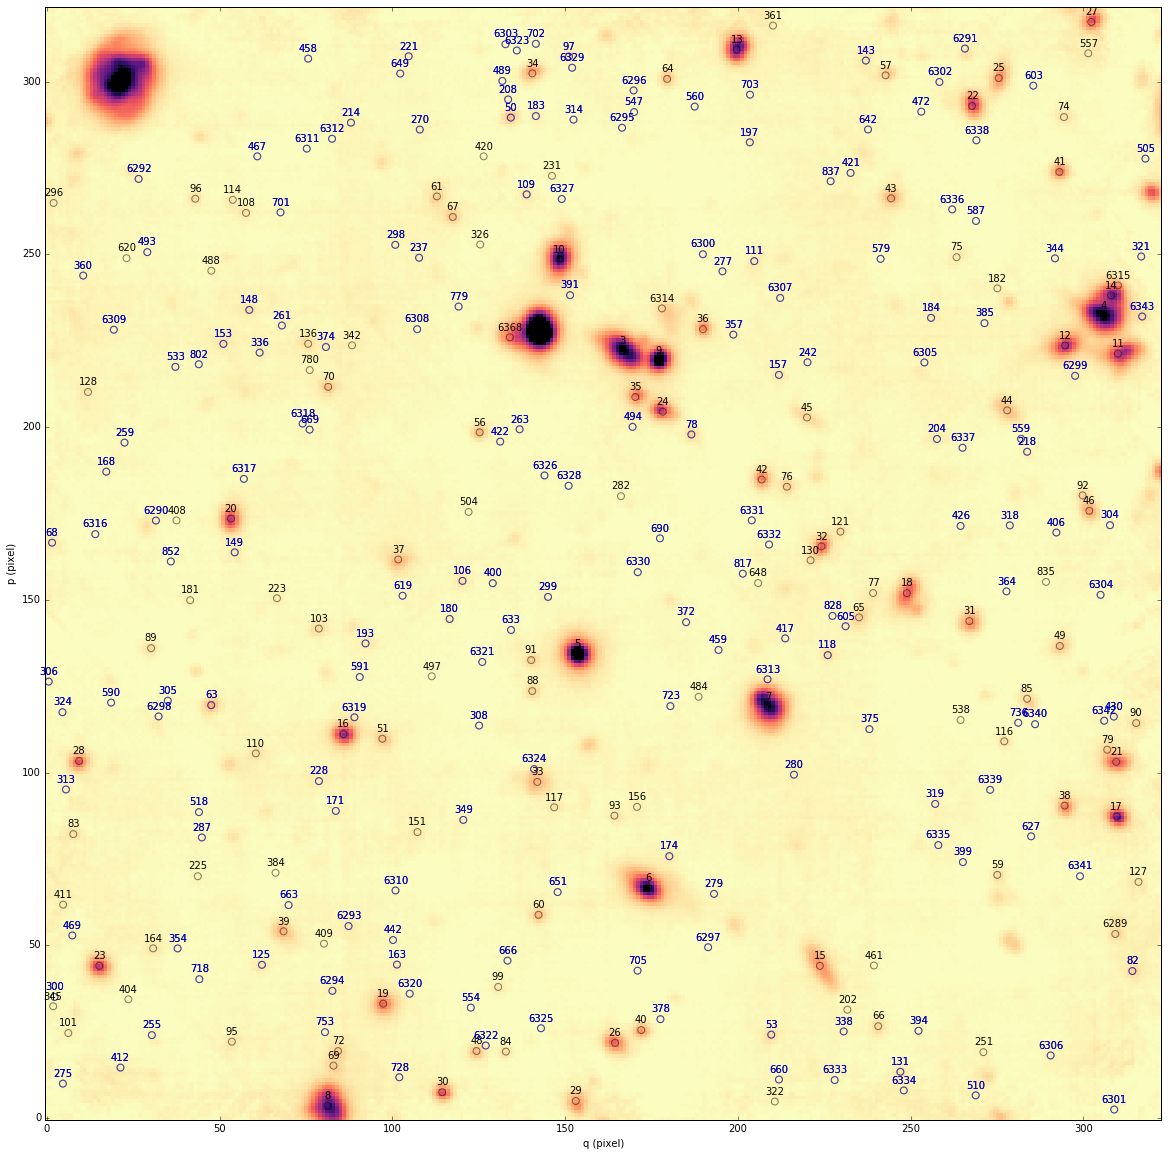

In [9]:
cat = Catalog.read('../data/udf10_c031_e026_withz.vot')

cat_lya=cat[cat['TYPE']==6]

im = cube.mean(axis=0)

fig = plt.figure(figsize=(20,20))
ax = plt.subplot(1,1,1)

im.plot(vmin=0,vmax=5,cmap='magma_r')
cat.plot_id(ax,im.wcs)
cat_lya.plot_id(ax,im.wcs,col='blue')

In [10]:

#src_list = SourceList.from_path('../data/udf10/sources')
liste_id = (78,149,153,157,183,208,214,237,547,619,802,828,6295)

sourcelist = list()
for id in liste_id:

    src= Source.from_file('../data/udf10_lya_sources_v0/udf10_'+str(id)+'.fits')
    sourcelist.append(src)


In [7]:
lambda_0 = 4750    # see Bacon et al, 2015
lambda_lya = 1216
pas_spectral = 1.25 # Angstrom / spectral band

W = 20
W_aff = 300
S = 50

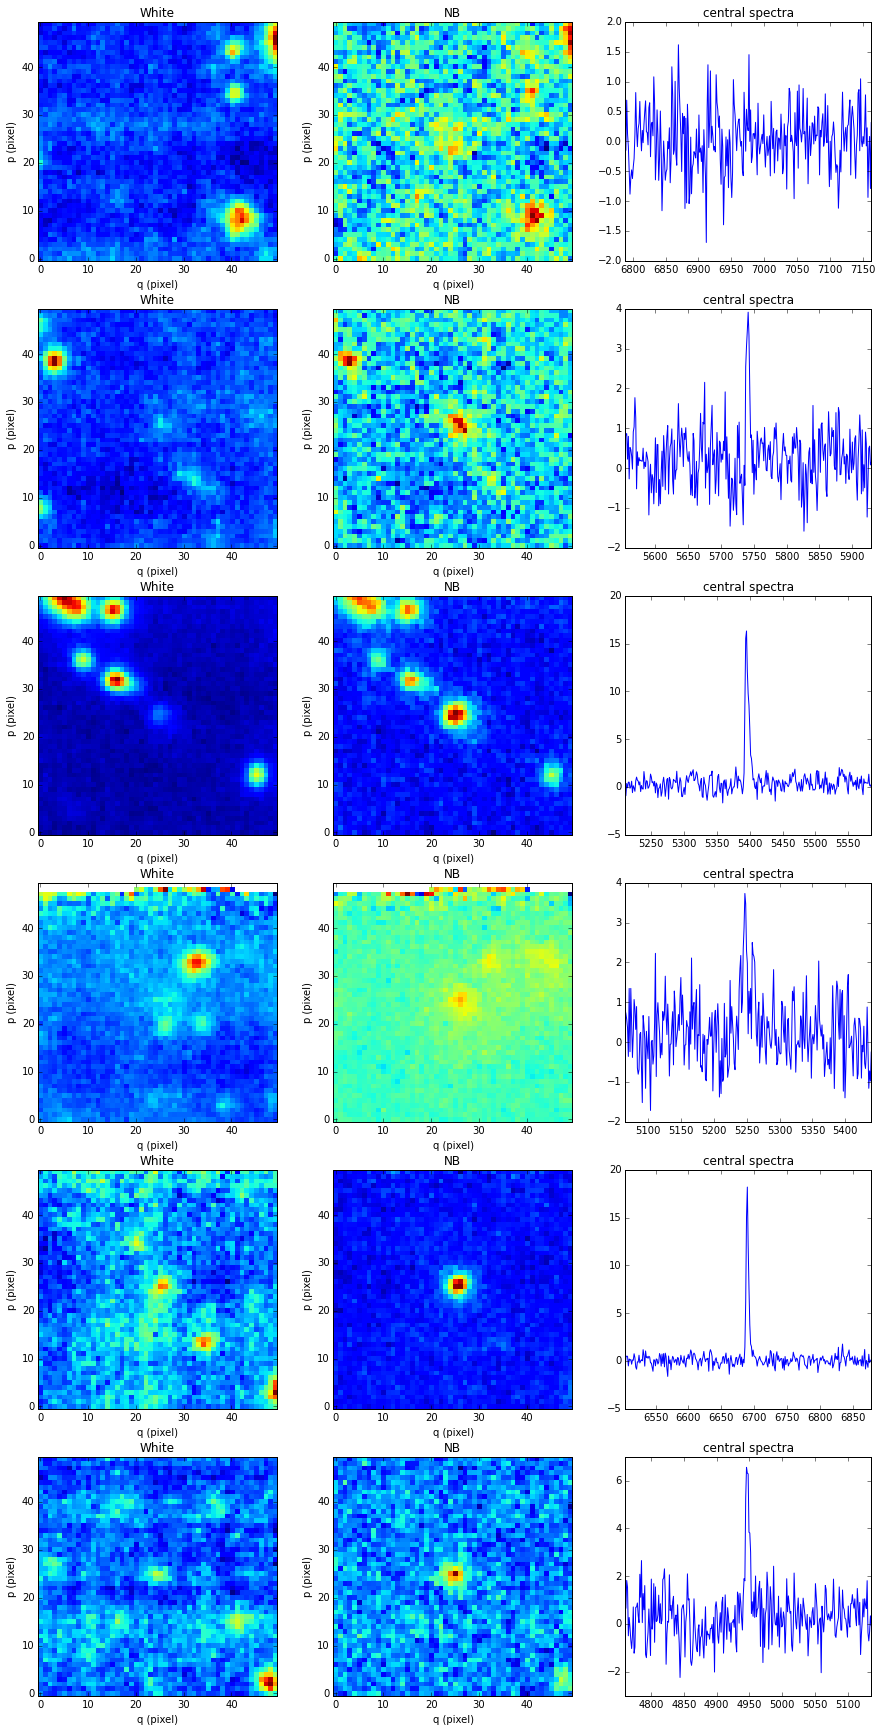

In [8]:
i = 1
nb_li=6
plt.figure(figsize=(3*5,nb_li*5))
for src in sourcelist:



    
    lam_ang = src.lines['lya_start'][0] +  0.5*(src.lines['lya_end'][0] - src.lines['lya_start'][0])

    deb_lar = lam_ang - W_aff/2 * pas_spectral
    if deb_lar < lambda_0: deb_lar = lambda_0 +1
    fin_lar = deb_lar+W_aff*pas_spectral
    
    
    sp_range_large = np.arange(deb_lar,fin_lar+1,pas_spectral)
    sub_cube_large = cube.subcube((src.dec,src.ra),S,lbda=(deb_lar,fin_lar),pix=True)
    
    deb = lam_ang - W/2*pas_spectral
    if deb < lambda_0: deb = lambda_0 + 1
    fin = deb+W*pas_spectral
    sub_cube_tight = cube.subcube((src.dec,src.ra),S,lbda=(deb,fin),pix=True)
    
    
    ax = plt.subplot(nb_li,3,i)
    im = sub_cube_large.sum(axis=0)
    im.plot()
    plt.title('White')
    
    ax = plt.subplot(nb_li,3,i+1)
    im = sub_cube_tight.sum(axis=0)
    im.plot()
    plt.title('NB')
    
    ax = plt.subplot(nb_li,3,i+2)
    Y_src = np.swapaxes(sub_cube_large.get_np_data(),2,0)
    plt.plot(sp_range_large, Y_src[int(S/2),int(S/2),:]) #deb_lar+np.arange(0,W_aff+1)*pas_spectral,
    plt.xlim((sp_range_large[0], sp_range_large[-1]))
    plt.title('central spectra')
    
    i +=3

In [9]:
Y_src[int(S/2),int(S/2),:].shape

(301,)

In [10]:
src_list[3].id

208

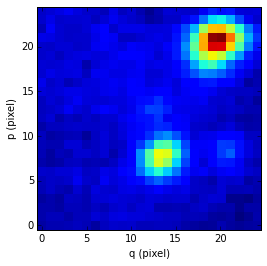

In [11]:
src_list[3].images['MUSE_WHITE'].plot()

In [13]:
import parameters

In [14]:
nb_li = 6
nb_col = 3
plt.figure(figsize=(nb_col*5,nb_li*5))

i=1
num_obj = 1
for src in (src_list[3],):

    #if num_obj==4:
    S =90
        
    #else:
    #    S = 50
        #continue
        
    print num_obj
    # Method parameters
    pfa_faint=0.0001
    pfa_bright=0.01
    diag = 1
    P = 1
    taille_f = 11
    beta=2.6
    PFA = np.array([0.1,0.01,0.001, 0.0001])
    
    lam_ang = src.lines['lya_start'][0] +  0.5*(src.lines['lya_end'][0] - src.lines['lya_start'][0])
    fwhm_courant = calcul_fwhm(lam=lam_ang*pas_spectral + lambda_0)


    
    deb_lar = lam_ang - W_aff/2 * pas_spectral
    pos_ligne = W_aff/2 # en bande
    if deb_lar < lambda_0: 
        deb_lar = lambda_0 +1
        pos_ligne = lam_ang*pas_spectral
        
    fin_lar = deb_lar+W_aff*pas_spectral
    
    sp_range_large = np.arange(deb_lar,fin_lar+1,pas_spectral)
    sub_cube_large = cube.subcube((src.dec,src.ra),S,lbda=(deb_lar,fin_lar),pix=True)
    
    Y_src = np.swapaxes(sub_cube_large.get_np_data(),2,0)
    ############
    # Ensuring cube is "square"
    diff_size = Y_src.shape[0]-Y_src.shape[1]
    if diff_size!=0:
        taille = max( Y_src.shape[0],Y_src.shape[1])
        Y_src_new = np.zeros((taille,taille,Y_src.shape[2])) + np.nan
        Y_src_new[:Y_src.shape[0],:Y_src.shape[1],:] = Y_src
        Y_src = Y_src_new
    ############    
    ss_cube_medfilt = si.medfilt(Y_src,(1,1,301))
    Y_ms = Y_src - ss_cube_medfilt
    

    deb = lam_ang - W/2*pas_spectral
    if deb < lambda_0: deb = lambda_0 + 1
    fin = deb+W*pas_spectral
    
    Y_ms = Y_ms[:,:,pos_ligne-W/2:pos_ligne+W/2]
    
    centre = np.array([int(S/2),int(S/2)])
    #res, val, ests, X_init, val_init = sd.detection_strategy(Y_ms, P, diag, pfa_bright, pfa_faint, fwhm_courant, taille_f, beta,centre)
    params = parameters.Params(Y_ms,
                           centre,
                           pfa_bright=pfa_bright,
                           pfa_faint=pfa_faint,
                           FWHM=fwhm_courant)


    params.confident=False


    Xe1,ve1,vem1,Xi,vi = sdp.detection_strategy(params) 

        
    beta=2.6
    pas = 0.15
    nb_ech_dic = 50

    taille_f = 11
    marge = int(taille_f/2)

    F = dp.Moffat(taille_f, fwhm_courant,beta)
    D = dp.gen_dic(W, pas = pas, nb_ech=nb_ech_dic,asym=0)
    #-------- Moments calculation
    im_ind_est,im_weight_est = mse.get_sparse_estimate(Y_ms,F,D)
    flux,position,largeur = mse.get_moments(im_ind_est,im_weight_est,D,W,pas,pas_spectral)
    # recasting into original shape (to go inside the latter function)
    flux_new = np.zeros((flux.shape[0]+2*marge, flux.shape[1]+2*marge))+np.nan; 
    position_new = np.copy(flux_new)
    largeur_new = np.copy(flux_new)

    flux_new[marge:-marge,marge:-marge]=flux ; flux = flux_new
    position_new[marge:-marge,marge:-marge]=position ; position = position_new
    largeur_new[marge:-marge,marge:-marge]=largeur ; largeur = largeur_new

    #------- Spectra retrieving ----#

    Y_aff = Y_src
    W_aff = Y_src.shape[2]

    # Initial detection region
    reg_init = ma.masked_array(Y_aff, np.tile(np.invert(X_init)[:,:,np.newaxis], (1,1,W_aff)))
    sp_init = ma.mean(ma.mean(reg_init, axis=0), axis=0)

    # Outer detected region, connex to the center
    ma_ext = morph.binary_propagation(X_init, mask = res) - X_init
    reg_ext = ma.masked_array(Y_aff, np.tile(np.invert(ma_ext)[:,:,np.newaxis], (1,1,W_aff)))
    sp_ext = ma.mean(ma.mean(reg_ext, axis=0), axis=0)

    ma_tout = (res+X_init)>0
    # Outer detected regions, non-connex to the center
    ma_ext_pani = (res*(ma_ext==0)>0)
    reg_ext_pani = ma.masked_array(Y_aff, np.tile(np.invert(ma_ext_pani)[:,:,np.newaxis], (1,1,W_aff)))
    sp_ext_pani = ma.mean(ma.mean(reg_ext_pani, axis=0), axis=0)

    # Outside 
    reg_reste = ma.masked_array(Y_aff, np.tile(ma_ext[:,:,np.newaxis], (1,1,W_aff)))
    sp_reste = ma.mean(ma.mean(reg_reste, axis=0), axis=0)
    sp_reste_ex = Y_aff[-1,0,:] # exemple

    #------------ SNR calculation
    bruit_tab = np.reshape(reg_reste,(reg_reste.shape[0]**2,reg_reste.shape[2]))
    sigma_bruit = np.ma.cov(bruit_tab[~np.isnan(bruit_tab).all(1)],rowvar=0)

    if sp_ext.sum()!=0:
        rsb = 10.*np.log10((np.linalg.norm(sp_ext)**2)/np.trace(sigma_bruit))
    else:
        rsb = -1000


    #--------------------------------------#
    #-------Results retrievings------------#
    #----------(MPDAF Objects)-------------#

    wcs1 = sub_cube_tight.wcs
    waveloc=sub_cube_large.wave

    #li = LAMBDA_LINES[src.id]['lambda']     # li = LAMBDA_LINES[src.id]['lambda']        

    # 1) Images (binary + statistics)
    im_wh = sub_cube_large.get_image((sub_cube_large.get_range()[0,0],sub_cube_large.get_range()[1,0]))
    im_nb = sub_cube_large.get_image((src.lines['lya_start'][0],src.lines['lya_end'][0]))

    wcs1 = im_wh.wcs
    im_det_cont = Image(wcs=wcs1, data=val.T)
    im_det = Image(wcs=wcs1, data=(res.T-X_init.T)>0)
    im_det_gal = Image(wcs=wcs1, data=X_init.T)
    im_det_all = Image(wcs=wcs1, data=((res.T+X_init.T)>0))

    # 1b) Moments
    im_flux = Image(wcs=wcs1, data=flux.T)
    im_position = Image(wcs=wcs1, data=position.T)
    im_largeur = Image(wcs=wcs1, data=largeur.T)

    dic_images = {'MUSE_WHITE':im_wh, 'MUSE_NB':im_nb, 'DET_STAT':im_det_cont,'DET_BIN_ALL':im_det_all, 'DET_BIN_HAL':im_det,'DET_BIN_GAL':im_det_gal,'FLUX':im_flux, 'POSITION':im_position, 'FWHM':im_largeur}

    # 2) Detection spectra
    spe_centre = Spectrum(data=sp_init,wave=waveloc)
    spe_ext = Spectrum(data=sp_ext,wave=waveloc)
    spe_ext_pani = Spectrum(data=sp_ext_pani,wave=waveloc)
    spe_reste= Spectrum(data=sp_reste,wave=waveloc)  
    spe_reste_ex= Spectrum(data=sp_reste_ex,wave=waveloc)  

    dic_spectres = {'CENTER':spe_centre, 'PERIPH_ADJ':spe_ext,'PERIPH_NOADJ':spe_ext_pani, 'EXT':spe_reste, 'EXTEX':spe_reste_ex}# 'MUSE_NB':im_nb, 'DET_CONT':im_det_cont, 'DET':im_det}


    objet=Source.from_data(ID=src.id,z=src.z,lines=src.lines,ra=src.ra,dec=src.dec,origin=('HEOLHT', version, 'HDFS-1.24'), images=dic_images, spectra=dic_spectres)
    objet.add_comment(comment='Flux, largeur et position sont indicatifs',author='JBC')
    objet.fwhm_pix= (fwhm_courant,'FWHM_PIX')
    objet.im_size = (S,'IM_SIZE')
    objet.snr_est = (rsb,'SNR_EST')
    objet.im_margin = (marge,'unused margin within detection images')

    #objet.write(nom_dossier+'ID'+str(src.id)+'.fits')
    
    
    ###### Some display (illustrative)
    ax = plt.subplot(nb_li,nb_col,num_obj+1)
    val_aff_max = ma.masked_array(val,X_init!=1).min()
    plt.imshow(val.T, origin='lower',vmin=0,vmax=val_aff_max,cmap=plt.cm.Blues,interpolation='nearest')
    
    ksi = st.chi2.isf(PFA, df=X_init.sum())
    plt.contour(val.T, ksi)

    plt.title('ID #'+str(src.id))


    
    num_obj+=1
    i+=1
    
plt.tight_layout()

1


TypeError: get_sparse_estimate() takes exactly 1 argument (3 given)

In [15]:



#if num_obj==4:
S =90

#else:
#    S = 50
    #continue

print num_obj
# Method parameters
pfa_faint=0.0001
pfa_bright=0.01
diag = 1
P = 1
taille_f = 11
beta=2.6
PFA = np.array([0.1,0.01,0.001, 0.0001])

lam_ang = src.lines['lya_start'][0] +  0.5*(src.lines['lya_end'][0] - src.lines['lya_start'][0])
fwhm_courant = calcul_fwhm(lam=lam_ang*pas_spectral + lambda_0)



deb_lar = lam_ang - W_aff/2 * pas_spectral
pos_ligne = W_aff/2 # en bande
if deb_lar < lambda_0: 
    deb_lar = lambda_0 +1
    pos_ligne = lam_ang*pas_spectral

fin_lar = deb_lar+W_aff*pas_spectral

sp_range_large = np.arange(deb_lar,fin_lar+1,pas_spectral)
sub_cube_large = cube.subcube((src.dec,src.ra),S,lbda=(deb_lar,fin_lar),pix=True)

Y_src = np.swapaxes(sub_cube_large.get_np_data(),2,0)
############
# Ensuring cube is "square"
diff_size = Y_src.shape[0]-Y_src.shape[1]
if diff_size!=0:
    taille = max( Y_src.shape[0],Y_src.shape[1])
    Y_src_new = np.zeros((taille,taille,Y_src.shape[2])) + np.nan
    Y_src_new[:Y_src.shape[0],:Y_src.shape[1],:] = Y_src
    Y_src = Y_src_new
############    
ss_cube_medfilt = si.medfilt(Y_src,(1,1,301))
Y_ms = Y_src - ss_cube_medfilt


deb = lam_ang - W/2*pas_spectral
if deb < lambda_0: deb = lambda_0 + 1
fin = deb+W*pas_spectral

Y_ms = Y_ms[:,:,pos_ligne-W/2:pos_ligne+W/2]

centre = np.array([int(S/2),int(S/2)])
#res, val, ests, X_init, val_init = sd.detection_strategy(Y_ms, P, diag, pfa_bright, pfa_faint, fwhm_courant, taille_f, beta,centre)
params = parameters.Params(Y_ms,
                       centre,
                       pfa_bright=pfa_bright,
                       pfa_faint=pfa_faint,
                       FWHM=fwhm_courant)


params.confident=False


Xe1,ve1,vem1,Xi,vi = sdp.detection_strategy(params) 

1


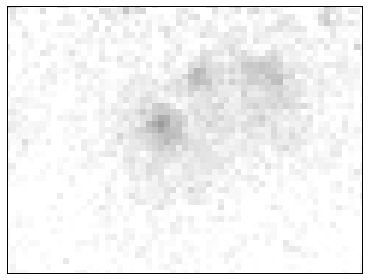

In [17]:
ax1 = plt.subplot(111)

ax1.imshow(Y_src[:,:,pos_ligne-W/2:pos_ligne+W/2].mean(axis=2).T,origin='lower',interpolation='nearest',cmap=plt.cm.gray_r,vmin=0)
#plt.contour(Xi.T,1,colors='b')
#ax1.contour(Xi.T,1,colors='k',linestyles='--')

ksi = st.chi2.isf(PFA, df=Xi.sum())
#plt.contour(ve1.T, ksi)


plt.ylim((20,65))
plt.xlim((20,80))

plt.tick_params(axis='x', labelbottom='off',top='off',bottom='off')
plt.tick_params(axis='y', labelleft='off',left='off',right='off')

plt.tight_layout()

#plt.savefig('../results/figures/udf10_wh.eps', format='eps',dpi=100)

In [24]:
Y_src[:,:,pos_ligne-W/2:pos_ligne+W/2]
np.savez('lyabig.npz',Y=Y_src)

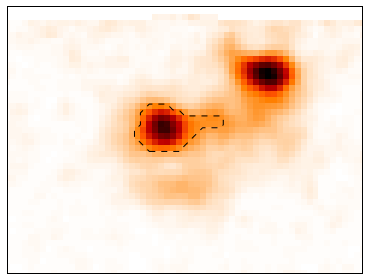

In [135]:
ax1 = plt.subplot(111)

ax1.imshow(vi.T,origin='lower',interpolation='nearest',cmap=plt.cm.gist_heat_r,vmin=0)
#plt.contour(Xi.T,1,colors='b')
ax1.contour(Xi.T,1,colors='k',linestyles='--')

ksi = st.chi2.isf(PFA, df=Xi.sum())
#plt.contour(ve1.T, ksi)


plt.ylim((20,65))
plt.xlim((20,80))

plt.tick_params(axis='x', labelbottom='off',top='off',bottom='off')
plt.tick_params(axis='y', labelleft='off',left='off',right='off')

plt.tight_layout()

plt.savefig('../results/figures/udf10_init.eps', format='eps',dpi=100)

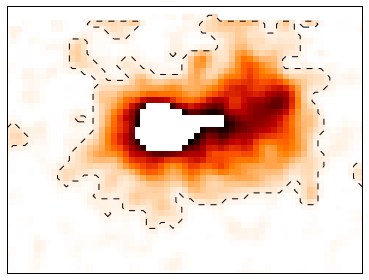

In [136]:
ax1 = plt.subplot(111)

ax1.imshow(ve1.T*(1-Xi.T),origin='lower',interpolation='nearest',cmap=plt.cm.gist_heat_r,vmin=0)
#plt.contour(Xi.T,1,colors='b')
ax1.contour(Xe1.T,1,colors='k',linestyles='--')

ksi = st.chi2.isf(PFA, df=Xi.sum())
#plt.contour(ve1.T, ksi)


plt.ylim((20,65))
plt.xlim((20,80))
#plt.axis('off')
#ax1.get_xaxis().tick_bottom()
#ax1.get_yaxis().tick_left()
plt.tick_params(axis='x', labelbottom='off',top='off',bottom='off')
plt.tick_params(axis='y', labelleft='off',left='off',right='off')

plt.tight_layout()
plt.savefig('../results/figures/udf10_ext.eps', format='eps',dpi=100)

In [ ]:
src_list = SourceList.from_path(nom_dossier)
doc_pdf = PdfPages(nom_dossier+'LAE-catalog-HDFS-1.24.pdf')
nb_li = 3
nb_col = 3
num_plot=1
amin = 0
amax=None
i=1
num_obj = 1
for num_obj in range(6):
    #if num_obj > 1 :
    #    continue
    Fig = plt.figure(figsize=(nb_col*4.5,4*nb_li))
    colmap=plt.cm.Blues
    src = src_list[num_obj]
    

        
    print str(src.id)
    
    val = src.images['DET_STAT'].get_np_data()
    init = src.images['DET_BIN_GAL'].get_np_data()
    res = src.images['DET_BIN_ALL'].get_np_data()
    ksi = st.chi2.isf(PFA, df=init.sum())
    
    flux = src.images['FLUX'].get_np_data()
    position = src.images['POSITION'].get_np_data()
    largeur = src.images['FWHM'].get_np_data()
    
    #plt.contour(val.T, ksi)
    #-------------------------------------#
    #-------- Display   ------------------#
    #-------------------------------------#
    # Text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    texte = 'ID #%d \n  $\\hat{\mathrm{SNR}} =%.2f \mathrm{dB}$ '%(src.id,  src.snr_est )#' +str(num_lya[obj])+ ' \n z = '+ str(z_lya[obj]) + '\n SNR = '+str(rsb)+'dB'
    plt.suptitle(texte, bbox=props,fontsize=14)

    # 1st image: white image + catalog sources in the projected neighborhood
    ax1 = Fig.add_subplot(nb_li,nb_col, 1)

    ## All sources :
    #plt.scatter(coords[0,:]-xmin, coords[1,:]-ymin, s=75, c='b');
    ## All sources with a close redshift (+/- 0.1)
    #indices = np.abs(coords[2,:] - coords[2,num_lya[obj]])<0.1
    #plt.scatter(coords[0,indices]-xmin, coords[1,indices]-ymin, s=150, c='r');
    src.show_ima(ax1, 'MUSE_WHITE',cuts=(amin, amax))

    plt.axis('on')
    plt.title('Image blanche')
    #plt.xlim([0,S]); plt.ylim([0,S])
    #-------------------------------------#
    # Second image : NB image + detection contours
    ax2 = Fig.add_subplot(nb_li,nb_col, 2)
    src.show_ima(ax2, 'MUSE_NB',cuts=(amin, amax))
    ax2.axis('on')
    plt.contour((res+init>0), 1,colors='#760000')
    plt.contour((init), 1,colors='r',linestyle='dashed')
    plt.title('NB, Detection gal. ($P_\mathrm{FA}=10^{-2}$) et halo ($\mathrm{max}(P_\mathrm{FA})=10^{-4}$)')

    #-------------------------------------#
    # 3rd image : statistic map and detection contour for various PFA.
    ax3 = Fig.add_subplot(nb_li,nb_col, 3)
    val_aff_max = ma.masked_array(val,init!=1).min()
    plt.imshow(val, origin='lower',vmin=0,vmax=val_aff_max,cmap=colmap,interpolation='nearest')
    plt.contour(val, ksi)
    plt.title('Stat. et niveau ($10^{-4}\\leq \mathrm{max}(P_{FA}) \\leq 10^{-1}$)')
    ax3.axis('on')
    #-------------------------------------#
    # 4th image (second line) : spectra
    ax45 = Fig.add_subplot(nb_li,nb_col, (4,5))
    plt.title('Spectres par region')
    ax45.axis('on')

    src.show_spec(ax45, 'CENTER',label='Centre')
    src.show_spec(ax45, 'PERIPH_ADJ',label='Etendu connexe')
    src.show_spec(ax45, 'PERIPH_NOADJ',label='E. non connexe')
    src.show_spec(ax45, 'EXT',label='Exterieur')
   
    plt.xlim(src.spectra['CENTER'].get_range())
    plt.legend()
    #-------------------------------------#
    # 5th image : FWHM of the FSF
    #ax6 = Fig.add_subplot(nb_li,nb_col,6)

    #F1 = dp.Moffat(S+1, 0.75*5,beta)
    #plt.imshow(F1, interpolation = 'Nearest',vmin=0, cmap = plt.cm.gray_r,origin='lower') ; 
    #plt.title('FSF et sa FWHM pour $\\lambda_0$') ; 
    #circle1=plt.Circle((int(S/2),int(S/2)),fwhm_courant,color='r',fill=False)
    #ax6.add_artist(circle1)

    #-------- Moments -------------#
    ## Displayed on the 6th, 7th and 8th image, last line.
    ax7 = Fig.add_subplot(nb_li,nb_col, 7)
    detec= (res+init>0)
    detec = detec[marge:S-marge,marge:S-marge]
    plt.xlabel('q (pixel)'); plt.ylabel('p (pixel)')
    plt.imshow(flux,interpolation= 'nearest', vmin = 0, cmap=plt.cm.gray_r,origin='lower')
    plt.title(' Flux estime')
    ax7.axis('on')
    plt.colorbar(fraction=0.046, pad=0.04)
    if detec.sum()!=0:
        plt.contour(res, 1,linewidths=2,colors='#760000')

    ax8 = Fig.add_subplot(nb_li,nb_col, 8)
    plt.imshow(position, interpolation= 'nearest',cmap=plt.cm.Spectral,origin='lower')
    plt.xlabel('q (pixel)'); plt.ylabel('p (pixel)')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('Position estimee')
    ax8.axis('on')
    if detec.sum()!=0:
        plt.contour(res, 1,linewidths=2,colors='w')

    ax9 = Fig.add_subplot(nb_li,nb_col, 9)
    
    plt.imshow(largeur, interpolation = 'nearest',cmap=plt.cm.coolwarm,origin='lower')
    plt.xlabel('q (pixel)'); plt.ylabel('p (pixel)')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('FWHM estimee')
    ax9.axis('on')
    plt.tight_layout()
    if detec.sum()!=0:
        plt.contour(res, 1,linewidths=2,colors='w')

    plt.subplots_adjust(top=0.85)

    num_plot +=1
    doc_pdf.savefig(Fig)
    plt.close(Fig)
            
          

#doc_pdf.close()

In [ ]:
src.z